In [1]:
import json 
import pandas as pd 
import numpy as np 
import time 
from datetime import timezone 
import os
from mplfinance.original_flavor import candlestick_ohlc
import pyupbit 
import ccxt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from transformers import *
import os 
import time 
import datetime 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns

PyTorch version 1.7.1 available.
TensorFlow version 2.5.0 available.
/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Preprocess Data

In [2]:
btc_2019 = pd.read_csv("data_5m/2019_BTCUSDT.csv") 
btc_2020 = pd.read_csv("data_5m/2020_BTCUSDT.csv") 
btc_2021 = pd.read_csv("data_5m/2021_BTCUSDT.csv") 
btc_2022 = pd.read_csv("data_5m/2022_BTCUSDT.csv") 

eth_2019 = pd.read_csv("data_5m/2019_ETHUSDT.csv") 
eth_2020 = pd.read_csv("data_5m/2020_ETHUSDT.csv") 
eth_2021 = pd.read_csv("data_5m/2021_ETHUSDT.csv") 
eth_2022 = pd.read_csv("data_5m/2022_ETHUSDT.csv") 

btc_2019.shape, btc_2020.shape, btc_2021.shape, btc_2022.shape, eth_2019.shape, eth_2020.shape, eth_2021.shape, eth_2022.shape

((105291, 7),
 (105685, 7),
 (105448, 7),
 (11361, 7),
 (105291, 7),
 (105685, 7),
 (105448, 7),
 (11364, 7))

In [3]:
btc_train = pd.concat([btc_2019, btc_2020, btc_2021]) 
eth_train = pd.concat([eth_2019, eth_2020, eth_2021]) 

btc_val = btc_2022 
eth_val = eth_2022

btc_train.shape, eth_train.shape, btc_val.shape, eth_val.shape

((316424, 7), (316424, 7), (11361, 7), (11364, 7))

In [4]:
def process(df): 
    binance = ccxt.binance() 
    dates = df['Open Time'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'0'})
    return df

In [5]:
btc_train = process(btc_train) 
eth_train = process(eth_train) 

btc_val = process(btc_val) 
eth_val = process(eth_val)

In [6]:
btc_train = btc_train.rename(columns={'Open':"BTC Open",
                                      'High':"BTC High", 
                                      'Low':"BTC Low",
                                      'Close':"BTC Close",
                                      'Volume':"BTC Volume"})

In [7]:
eth_train = eth_train.rename(columns={'Open':"ETH Open",
                                      'High':"ETH High", 
                                      'Low':"ETH Low",
                                      'Close':"ETH Close",
                                      'Volume':"ETH Volume"})

In [8]:
btc_train = btc_train.drop(columns={'Open Time'}) 
eth_train = eth_train.drop(columns={'Open Time'})
full_df = btc_train.join(eth_train.set_index('datetime'), on='datetime') 

In [9]:
full_df = full_df.dropna() 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume
0,3701.23,3703.72,3695.00,3696.32,85.572181,2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705
1,3696.30,3697.24,3689.88,3692.34,62.296581,2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843
2,3692.34,3698.93,3692.34,3697.31,43.105333,2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337
3,3697.91,3698.75,3693.00,3693.00,48.551084,2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505
4,3693.44,3695.98,3690.92,3692.18,47.706443,2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218


In [10]:
minutes = [] 
hours = []
days = [] 
months = [] 
for dt in tqdm(full_df['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    minutes.append(minute)
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    
full_df['Minutes'] = minutes
full_df['Hours'] = hours
full_df['Days'] = days 
full_df['Months'] = months 

100%|██████████| 319572/319572 [03:13<00:00, 1649.63it/s]


In [11]:
full_df = full_df.drop(columns={'datetime'}) 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,3701.23,3703.72,3695.00,3696.32,85.572181,131.45,131.54,131.01,131.27,1269.12705,0,0,1,1
1,3696.30,3697.24,3689.88,3692.34,62.296581,131.26,131.35,131.12,131.29,1601.91843,5,0,1,1
2,3692.34,3698.93,3692.34,3697.31,43.105333,131.27,131.36,131.19,131.31,560.54337,10,0,1,1
3,3697.91,3698.75,3693.00,3693.00,48.551084,131.30,131.36,131.25,131.30,651.89505,15,0,1,1
4,3693.44,3695.98,3690.92,3692.18,47.706443,131.26,131.44,131.25,131.28,500.58218,20,0,1,1


In [46]:
def differencing(df, lookback=121): 
    columns = ["BTC Open", "BTC High", "BTC Low", "BTC Close", "BTC Volume", 
               "ETH Open", "ETH High", "ETH Low", "ETH Close", "ETH Volume"]
    for col in columns: 
        close = df[col].values 
        d = {} 
        for i in range(1, lookback): 
            d['{}_Differenced_{}'.format(col, i)] = []
        for i in tqdm(range(df.shape[0]), position=0, leave=True): 
            if i < lookback: 
                for j in range(1, lookback): 
                    d['{}_Differenced_{}'.format(col, j)].append(None)
            else: 
                for j in range(1, lookback): 
                    epsilon = 0
                    if col == "BTC Volume" or col == "ETH Volume": 
                        epsilon = 1e-10
                    ret = close[i] / (close[i-j] + epsilon) 
                    d['{}_Differenced_{}'.format(col, j)].append(ret) 
        for key, value in d.items():
            df[key] = value
    return df 

def feature_engineering(df): 
    windows = [5, 10, 20, 60, 120]

    for window in windows: 
        df['BTC_Open_ma{}'.format(window)] = df['BTC Open'].rolling(window).mean() 
        df['BTC_Open_ma{}_ratio'.format(window)] = (df['BTC Open'] - df['BTC_Open_ma{}'.format(window)]) / df['BTC_Open_ma{}'.format(window)]

        df['BTC_High_ma{}'.format(window)] = df['BTC High'].rolling(window).mean()
        df['BTC_High_ma{}_ratio'.format(window)] = (df['BTC High'] - df['BTC_High_ma{}'.format(window)]) / df['BTC_High_ma{}'.format(window)]

        df['BTC_Low_ma{}'.format(window)] = df['BTC Low'].rolling(window).mean() 
        df['BTC_Low_ma{}_ratio'.format(window)] = (df['BTC Low'] - df['BTC_Low_ma{}'.format(window)]) / df['BTC_Low_ma{}'.format(window)]
        
        df['BTC_Close_ma{}'.format(window)] = df['BTC Close'].rolling(window).mean() 
        df['BTC_Close_ma{}_ratio'.format(window)] = (df['BTC Close'] - df['BTC_Close_ma{}'.format(window)]) / df['BTC_Close_ma{}'.format(window)]

        df['BTC_Volume_ma{}'.format(window)] = df['BTC Volume'].rolling(window).mean() 
        df['BTC_Volume_ma{}_ratio'.format(window)] = (df['BTC Volume'] - df['BTC_Volume_ma{}'.format(window)]) / df['BTC_Volume_ma{}'.format(window)]
        
        df['ETH_Open_ma{}'.format(window)] = df['ETH Open'].rolling(window).mean() 
        df['ETH_Open_ma{}_ratio'.format(window)] = (df['ETH Open'] - df['ETH_Open_ma{}'.format(window)]) / df['ETH_Open_ma{}'.format(window)] 
        
        df['ETH_High_ma{}'.format(window)] = df['ETH High'].rolling(window).mean() 
        df['ETH_High_ma{}_ratio'.format(window)] = (df['ETH High'] - df['ETH_High_ma{}'.format(window)]) / df['ETH_High_ma{}'.format(window)] 
        
        df['ETH_Low_ma{}'.format(window)] = df['ETH Low'].rolling(window).mean() 
        df['ETH_Low_ma{}_ratio'.format(window)] = (df['ETH Low'] - df['ETH_Low_ma{}'.format(window)]) / df['ETH_Low_ma{}'.format(window)] 
        
        df['ETH_Close_ma{}'.format(window)] = df['ETH Close'].rolling(window).mean() 
        df['ETH_Close_ma{}_ratio'.format(window)] = (df['ETH Close'] - df['ETH_Close_ma{}'.format(window)]) / df['ETH_Close_ma{}'.format(window)]

        df['ETH_Volume_ma{}'.format(window)] = df['ETH Volume'].rolling(window).mean() 
        df['ETH_Volume_ma{}_ratio'.format(window)] = (df['ETH Volume'] - df['ETH_Volume_ma{}'.format(window)]) / df['ETH_Volume_ma{}'.format(window)]
        
    df = differencing(df) 

    return df

In [13]:
train_feature_engineered = feature_engineering(full_df) 

train_feature_engineered.tail()

100%|██████████| 319572/319572 [00:35<00:00, 9122.76it/s] 


,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,...,ETH Volume_Differenced_111,ETH Volume_Differenced_112,ETH Volume_Differenced_113,ETH Volume_Differenced_114,ETH Volume_Differenced_115,ETH Volume_Differenced_116,ETH Volume_Differenced_117,ETH Volume_Differenced_118,ETH Volume_Differenced_119,ETH Volume_Differenced_120
105443,46468.22,46468.23,46375.60,46383.95,37.76561,3695.54,3695.65,3689.18,3689.19,315.8267,...,0.537490,0.646211,0.574159,0.755968,0.416034,0.416034,0.416034,0.416034,0.400705,0.551308
105444,46383.94,46520.13,46382.71,46465.54,72.60896,3689.20,3695.78,3689.19,3693.29,1246.5390,...,2.114589,2.121422,2.550534,2.266153,2.983735,1.642046,1.642046,1.642046,1.642046,1.581545
105445,46465.54,46465.55,46379.00,46390.82,67.34943,3693.30,3693.51,3685.55,3686.59,319.5321,...,0.387732,0.542044,0.543796,0.653792,0.580895,0.764837,0.420915,0.420915,0.420915,0.420915
105446,46391.42,46391.42,46275.15,46285.80,119.26084,3686.59,3686.60,3677.81,3679.10,687.6308,...,0.625460,0.834397,1.166475,1.170244,1.406956,1.250083,1.645924,0.905805,0.905805,0.905805
105447,46285.79,46285.80,46132.04,46216.93,145.02017,3679.36,3679.36,3672.22,3676.23,505.1327,...,0.989896,0.459462,0.612947,0.856891,0.859660,1.033548,0.918309,1.209093,0.665403,0.665403


In [14]:
train_feature_engineered = train_feature_engineered.dropna() 

In [21]:
# predict returns for BTC Open for the next 6 steps
train_targets = [] 

open_prices = train_feature_engineered['BTC Open'].values
K = 6

for i in tqdm(range(open_prices.shape[0]-K)): 
    targets = [] 
    for j in range(1,7): 
        ret = open_prices[i+j] / open_prices[i+j-1] 
        targets.append(ret) 
    train_targets.append(targets) 
    
train_targets = torch.tensor(train_targets, dtype=torch.float32) 

train_targets.shape

100%|██████████| 319404/319404 [00:02<00:00, 140919.49it/s]


torch.Size([319404, 6])

In [24]:
remove_cols = ["BTC Open",
               "BTC High",
               "BTC Low", 
               "BTC Close", 
               "BTC Volume", 
               "ETH Open", 
               "ETH High", 
               "ETH Low", 
               "ETH Close", 
               "ETH Volume"] 

train_feature_engineered = train_feature_engineered.drop(columns=remove_cols) 

train_feature_engineered.head()

,Minutes,Hours,Days,Months,BTC_Open_ma5,BTC_Open_ma5_ratio,BTC_High_ma5,BTC_High_ma5_ratio,BTC_Low_ma5,BTC_Low_ma5_ratio,...,ETH Volume_Differenced_111,ETH Volume_Differenced_112,ETH Volume_Differenced_113,ETH Volume_Differenced_114,ETH Volume_Differenced_115,ETH Volume_Differenced_116,ETH Volume_Differenced_117,ETH Volume_Differenced_118,ETH Volume_Differenced_119,ETH Volume_Differenced_120
121,5,10,1,1,3701.532,-0.000168,3709.820,-0.001280,3698.732,0.000440,...,0.364132,0.331431,0.340415,0.769178,0.472835,0.713295,1.086227,0.834100,0.970033,0.339434
122,10,10,1,1,3702.390,0.000708,3705.570,0.001398,3699.570,0.001070,...,0.920277,0.458230,0.417078,0.428384,0.967947,0.595023,0.897624,1.366927,1.049646,1.220707
123,15,10,1,1,3703.400,0.001815,3706.900,0.001735,3701.286,0.001795,...,0.364979,0.702597,0.349842,0.318424,0.327055,0.738992,0.454279,0.685303,1.043599,0.801367
124,20,10,1,1,3705.762,0.001902,3709.948,0.001930,3704.308,0.002001,...,0.572661,0.303667,0.584569,0.291072,0.264932,0.272114,0.614850,0.377965,0.570180,0.868286
125,25,10,1,1,3708.832,0.001747,3712.452,0.000956,3706.708,0.000888,...,1.080580,1.011063,0.536140,1.032087,0.513903,0.467752,0.480431,1.085549,0.667317,1.006682


In [25]:
train_feature_engineered.to_csv("binance_train_feature_engineered.csv",index=False) 

In [48]:
btc_val = btc_val.rename(columns={'Open':"BTC Open",
                                      'High':"BTC High", 
                                      'Low':"BTC Low",
                                      'Close':"BTC Close",
                                      'Volume':"BTC Volume"})


eth_val = eth_val.rename(columns={'Open':"ETH Open",
                                      'High':"ETH High", 
                                      'Low':"ETH Low",
                                      'Close':"ETH Close",
                                      'Volume':"ETH Volume"})

#btc_val = btc_val.drop(columns={'Open Time'}) 
#eth_val = eth_val.drop(columns={'Open Time'})
full_val = btc_val.join(eth_val.set_index('datetime'), on='datetime')  

full_val = full_val.dropna() 

minutes = [] 
hours = []
days = [] 
months = [] 
for dt in tqdm(full_val['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    minutes.append(minute)
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    
full_val['Minutes'] = minutes
full_val['Hours'] = hours
full_val['Days'] = days 
full_val['Months'] = months  

full_val = full_val.drop(columns={'datetime'}) 

val_feature_engineered = feature_engineering(full_val) 

# predict returns for BTC Open for the next 6 steps
val_targets = [] 

open_prices = val_feature_engineered['BTC Open'].values
K = 6

for i in tqdm(range(open_prices.shape[0]-K)): 
    targets = [] 
    for j in range(1,7): 
        ret = open_prices[i+j] / open_prices[i+j-1] 
        targets.append(ret) 
    val_targets.append(targets) 
    
val_targets = torch.tensor(val_targets, dtype=torch.float32) 

val_targets.shape

100%|██████████| 11467/11467 [00:00<00:00, 192833.25it/s]


torch.Size([11467, 6])

In [31]:
val_feature_engineered = val_feature_engineered.dropna() 

val_feature_engineered = val_feature_engineered.drop(columns=remove_cols) 

val_feature_engineered.to_csv("binance_val_feature_engineered.csv",index=False) 

In [32]:
val_feature_engineered.head()

,Minutes,Hours,Days,Months,BTC_Open_ma5,BTC_Open_ma5_ratio,BTC_High_ma5,BTC_High_ma5_ratio,BTC_Low_ma5,BTC_Low_ma5_ratio,...,ETH Volume_Differenced_111,ETH Volume_Differenced_112,ETH Volume_Differenced_113,ETH Volume_Differenced_114,ETH Volume_Differenced_115,ETH Volume_Differenced_116,ETH Volume_Differenced_117,ETH Volume_Differenced_118,ETH Volume_Differenced_119,ETH Volume_Differenced_120
121,5,10,1,1,47094.390,0.002700,47165.344,0.001192,47057.192,0.001473,...,0.564899,0.290444,0.379701,0.359360,1.156656,1.219890,1.059894,0.900777,0.524068,0.457844
122,10,10,1,1,47129.900,0.000766,47192.064,0.000377,47089.928,0.000450,...,0.842758,0.445898,0.229259,0.299714,0.283658,0.912997,0.962910,0.836618,0.711021,0.413669
123,15,10,1,1,47138.418,-0.000579,47197.056,-0.001821,47086.428,-0.001515,...,0.624616,1.216548,0.643668,0.330943,0.432647,0.409470,1.317940,1.389992,1.207685,1.026382
124,20,10,1,1,47139.650,-0.001783,47180.808,-0.002502,47072.956,-0.002048,...,0.878752,0.958689,1.867212,0.987931,0.507947,0.664045,0.628472,2.022834,2.133422,1.853610
125,25,10,1,1,47118.866,-0.001672,47130.366,-0.001779,47008.448,-0.004158,...,2.822899,2.803658,3.058696,5.957340,3.151992,1.620603,2.118636,2.005141,6.453850,6.806681


In [56]:
val_feature_engineered.shape

(11352, 1304)

# Create DataLoader

To get the targets, for input at time t, we need to first differenced value of open i.e. for t, at t+1, we get BTC Open_Differenced_1, at t+2, we get BTC Open_Differenced_1,... at t+6 we get BTC Open_Differenced_1 

In [12]:
train_feature_engineered = pd.read_csv("binance_train_feature_engineered.csv") 
val_feature_engineered = pd.read_csv("binance_val_feature_engineered.csv")

In [13]:
# get rid of any rows with inf values - this may be possible due to zero volumes  
train_feature_engineered = train_feature_engineered.replace([np.inf, -np.inf], np.nan)
train_feature_engineered.dropna(inplace=True)

val_feature_engineered = val_feature_engineered.replace([np.inf, -np.inf], np.nan) 
val_feature_engineered.dropna(inplace=True)  

In [15]:
train_feature_engineered.shape, val_feature_engineered.shape

((318930, 1304), (11352, 1304))

In [16]:
drop_cols = [] 
for ticker in ["BTC","ETH"]: 
    for chart_info in ["Open", "High", "Low", "Close", "Volume"]: 
        for w in [5,10,20,60,120]:
            drop_cols.append("{}_{}_ma{}".format(ticker, chart_info, w)) 

relevant_cols = [] 
cols = train_feature_engineered.columns 

for col in cols: 
    if col not in drop_cols: 
        relevant_cols.append(col) 
        
train_feature_engineered = train_feature_engineered[relevant_cols] 
val_feature_engineered = val_feature_engineered[relevant_cols]

In [17]:
final_columns = train_feature_engineered.columns
final_columns

Index(['Minutes', 'Hours', 'Days', 'Months', 'BTC_Open_ma5_ratio',
       'BTC_High_ma5_ratio', 'BTC_Low_ma5_ratio', 'BTC_Close_ma5_ratio',
       'BTC_Volume_ma5_ratio', 'ETH_Open_ma5_ratio',
       ...
       'ETH Volume_Differenced_111', 'ETH Volume_Differenced_112',
       'ETH Volume_Differenced_113', 'ETH Volume_Differenced_114',
       'ETH Volume_Differenced_115', 'ETH Volume_Differenced_116',
       'ETH Volume_Differenced_117', 'ETH Volume_Differenced_118',
       'ETH Volume_Differenced_119', 'ETH Volume_Differenced_120'],
      dtype='object', length=1254)

In [19]:
K = 6
targets = [] 
rets = train_feature_engineered['BTC Open_Differenced_1'].values

train_future_disc = [] 
dates = train_feature_engineered[["Minutes","Hours","Days","Months"]].values   

for i in tqdm(range(train_feature_engineered.shape[0] - K)): 
    target = [] 
    for j in range(1,7): 
        target.append(rets[i+j]) 
    targets.append(target) 
    
    date = [] 
    for j in range(1,7): 
        date.append(dates[i+j,:]) 
    train_future_disc.append(date) 
    
targets = torch.tensor(targets, dtype=torch.float32) 
train_future_disc = torch.tensor(train_future_disc, dtype=torch.float32)
targets.shape, train_future_disc.shape

100%|██████████| 318924/318924 [00:03<00:00, 83074.14it/s] 


(torch.Size([318924, 6]), torch.Size([318924, 6, 4]))

In [20]:
val_targets = [] 
rets = val_feature_engineered['BTC Open_Differenced_1'].values 

val_future_discs = [] 
dates = val_feature_engineered[["Minutes", "Hours", "Days", "Months"]].values 

for i in range(val_feature_engineered.shape[0] - K): 
    target = []
    for j in range(1,7): 
        target.append(rets[i+j]) 
    val_targets.append(target) 
    
    date = [] 
    for j in range(1,7): 
        date.append(dates[i+j,:]) 
    val_future_discs.append(date)
    
val_targets = torch.tensor(val_targets, dtype=torch.float32) 
val_future_discs = torch.tensor(val_future_discs, dtype=torch.float32)
val_targets.shape, val_future_discs.shape

(torch.Size([11346, 6]), torch.Size([11346, 6, 4]))

In [21]:
train_feature_engineered = train_feature_engineered.iloc[:-6,:]
val_feature_engineered = val_feature_engineered.iloc[:-6,:] 

In [22]:
train_feature_engineered.shape, val_feature_engineered.shape

((318924, 1254), (11346, 1254))

In [23]:
# for processing discrete features 
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    # print("Converting to one hot vector")
    for i in range(0, x.shape[-1]): # get rid of tqdm for training 
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

In [24]:
disc_cols = ["Minutes", "Hours", "Days", "Months"] 
cont_cols = [] 
cols = train_feature_engineered.columns 

for col in cols: 
    if col not in disc_cols: 
        cont_cols.append(col) 
        
train_cont = train_feature_engineered[cont_cols].values 
val_cont = val_feature_engineered[cont_cols].values 

train_disc = train_feature_engineered[disc_cols].values 
val_disc = val_feature_engineered[disc_cols].values 


train_cont = torch.tensor(train_cont, dtype=torch.float32) 
val_cont = torch.tensor(val_cont, dtype=torch.float32) 

train_disc = torch.tensor(train_disc, dtype=torch.float32) 
val_disc = torch.tensor(val_disc, dtype=torch.float32) 

train_cont.shape, val_cont.shape, train_disc.shape, val_disc.shape

(torch.Size([318924, 1250]),
 torch.Size([11346, 1250]),
 torch.Size([318924, 4]),
 torch.Size([11346, 4]))

In [27]:
train_disc = torch.reshape(train_disc, (-1, 1, 4)) 
val_disc = torch.reshape(val_disc, (-1, 1, 4)) 

train_cont = torch.reshape(train_cont, (-1, 1, 1250, 1)) 
targets = torch.reshape(targets, (-1, 6, 1)) 

val_cont = torch.reshape(val_cont, (-1, 1, 1250, 1)) 
val_targets = torch.reshape(val_targets, (-1, 6, 1)) 

train_disc.shape, train_future_disc.shape, train_cont.shape, targets.shape, val_disc.shape, val_cont.shape, val_targets.shape, val_future_discs.shape 

(torch.Size([318924, 1, 4]),
 torch.Size([318924, 6, 4]),
 torch.Size([318924, 1, 1250, 1]),
 torch.Size([318924, 6, 1]),
 torch.Size([11346, 1, 4]),
 torch.Size([11346, 1, 1250, 1]),
 torch.Size([11346, 6, 1]),
 torch.Size([11346, 6, 4]))

In [29]:
BATCH_SIZE = 128

class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont
        self.past_disc = past_disc 
        self.target_seq = target_seq  
        self.future_disc = future_disc 
        
    def __len__(self): 
        return len(self.past_cont) 
    
    def __getitem__(self, i):  
        return {
            'past_cont': torch.tensor(self.past_cont[i], dtype=torch.float32), 
            'past_disc': torch.tensor(self.past_disc[i], dtype=torch.float32), 
            'target_seq': torch.tensor(self.target_seq[i], dtype=torch.float32),  
            'future_disc': torch.tensor(self.future_disc[i], dtype=torch.float32),  
        }

train_dataset = CustomDataset(train_cont, train_disc, targets, train_future_disc)
val_dataset = CustomDataset(val_cont, val_disc, val_targets, val_future_discs)  

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) 


In [30]:
features = train_cont.shape[2]
features

1250

# Define Temporal Fusion Transformer Model

In [31]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))


In [32]:
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 

In [33]:
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)

In [34]:
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        '''
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        '''
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 

        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
        

In [35]:
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

In [36]:
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 

In [37]:
model = TFN(n_var_past_cont = features,
            n_var_future_cont = 0, 
            n_var_past_disc = [60, 24, 32, 13], # minutes, hours, days, months
            n_var_future_disc = [60, 24, 32, 13],
            dim_model = 160) 

model.cuda()


TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=200640, out_features=1254, bias=True)
      (fc1): Linear(in_features=200640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=1254, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=1254, out_features=1254, bias=True)
        (fc2): Linear(in_features=1254, out_features=1254, bias=True)
      )
      (norm): LayerNorm((1254,), eps=1e-0

In [38]:
device = torch.device('cuda')

epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) 

train_losses, val_losses = [], []  

criterion = nn.MSELoss()  

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [39]:
def evaluate(data_dataloader): 
    eval_loss = 0 
    for step, batch in enumerate(tqdm(data_dataloader, desc="Iteration", smoothing=0.05, position=0, leave=True)): 
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device)
        
        past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
        future_disc = one_hot(future_disc, [60, 24, 32, 13]) 
        
        model.reset(batch_size=past_cont.shape[0], gpu=True) 
        with torch.no_grad():
            net_out, vs_weights = model(past_cont, past_disc, None, future_disc)  
        loss = criterion(net_out, target_seq)
        eval_loss += loss.item() 
    avg_val_loss = eval_loss / len(data_dataloader)    
    return avg_val_loss, net_out, vs_weights

In [40]:
for i in range(epochs): 
    print("")
    print("======= Epoch {:} / {:} =======".format(i+1, epochs))
    print("Training...") 
    total_loss = 0 
    model.train() 
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration", smoothing=0.05, position=0, leave=True)):
        if step%200 == 0 and not step == 0:
            print("current average loss = {:.5f}".format(total_loss / step))
                
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        model.reset(batch_size=past_cont.shape[0], gpu=True)
        past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
        future_disc = one_hot(future_disc, [60, 24, 32, 13])  
                
        optimizer.zero_grad() 
        net_out, vs_weights = model(past_cont, past_disc, None, future_disc) 
        
        loss = criterion(net_out, target_seq) 
        total_loss += loss.item() 
        loss.backward() # back propagation 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping 
        optimizer.step() 
        scheduler.step() 
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  
    
    print("Validating...")
    model.eval() 
    val_loss, _, _ = evaluate(val_dataloader) 
    val_losses.append(val_loss) 
    if np.min(val_losses) == val_losses[-1]: 
        print("Saving Best Checkpoint...") 
        torch.save(model.state_dict(), "TFT_feature_engineered.pt") 

print("") 
print("Training Complete!")


======= Epoch 1 / 50 =======
Training...


Iteration:   0%|          | 0/2492 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct f

current average loss = 0.06134


Iteration:  16%|█▌        | 400/2492 [02:40<12:17,  2.84it/s]

current average loss = 0.03252


Iteration:  24%|██▍       | 600/2492 [04:01<12:27,  2.53it/s]

current average loss = 0.02227


Iteration:  32%|███▏      | 800/2492 [05:22<11:16,  2.50it/s]

current average loss = 0.01697


Iteration:  40%|████      | 1000/2492 [06:42<10:07,  2.45it/s]

current average loss = 0.01371


Iteration:  48%|████▊     | 1200/2492 [08:02<08:20,  2.58it/s]

current average loss = 0.01150


Iteration:  72%|███████▏  | 1800/2492 [12:00<04:19,  2.67it/s]

current average loss = 0.00776


Iteration:  80%|████████  | 2000/2492 [13:18<03:05,  2.65it/s]

current average loss = 0.00700


Iteration:  88%|████████▊ | 2200/2492 [14:37<01:59,  2.44it/s]

current average loss = 0.00638


Iteration:  96%|█████████▋| 2400/2492 [15:52<00:35,  2.57it/s]

current average loss = 0.00586


Iteration: 100%|██████████| 2492/2492 [16:28<00:00,  2.52it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.74it/s]


Saving Best Checkpoint...

======= Epoch 2 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:17<15:03,  2.54it/s]

current average loss = 0.00011


Iteration:  16%|█▌        | 400/2492 [02:37<13:31,  2.58it/s]

current average loss = 0.00010


Iteration:  24%|██▍       | 600/2492 [03:54<11:44,  2.69it/s]

current average loss = 0.00009


Iteration:  32%|███▏      | 800/2492 [05:10<10:52,  2.59it/s]

current average loss = 0.00009


Iteration:  40%|████      | 1000/2492 [06:28<09:46,  2.55it/s]

current average loss = 0.00008


Iteration:  48%|████▊     | 1200/2492 [07:42<07:38,  2.82it/s]

current average loss = 0.00008


Iteration:  56%|█████▌    | 1400/2492 [09:01<07:05,  2.57it/s]

current average loss = 0.00008


Iteration:  64%|██████▍   | 1600/2492 [10:16<05:50,  2.54it/s]

current average loss = 0.00007


Iteration:  72%|███████▏  | 1800/2492 [11:35<04:17,  2.69it/s]

current average loss = 0.00007


Iteration:  80%|████████  | 2000/2492 [12:51<03:04,  2.66it/s]

current average loss = 0.00007


Iteration:  85%|████████▍ | 2107/2492 [13:33<02:28,  2.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Saving Best Checkpoint...

======= Epoch 4 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:19<15:39,  2.44it/s]

current average loss = 0.00002


Iteration:  24%|██▍       | 600/2492 [03:57<11:50,  2.66it/s]

current average loss = 0.00002


Iteration:  32%|███▏      | 800/2492 [05:14<11:22,  2.48it/s]

current average loss = 0.00002


Iteration:  40%|████      | 1000/2492 [06:31<09:06,  2.73it/s]

current average loss = 0.00002


Iteration:  48%|████▊     | 1200/2492 [07:50<08:55,  2.41it/s]

current average loss = 0.00002


Iteration:  56%|█████▌    | 1400/2492 [09:05<06:26,  2.82it/s]

current average loss = 0.00002


Iteration:  64%|██████▍   | 1600/2492 [10:27<05:51,  2.54it/s]

current average loss = 0.00002


Iteration:  72%|███████▏  | 1800/2492 [11:44<04:38,  2.48it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [13:02<03:10,  2.58it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [14:20<01:49,  2.66it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:39<00:37,  2.47it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [16:15<00:00,  2.55it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.49it/s]


Saving Best Checkpoint...

======= Epoch 5 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:20<15:26,  2.47it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:38<12:53,  2.70it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:53<12:38,  2.49it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:11<10:37,  2.65it/s]

current average loss = 0.00001


Iteration:  37%|███▋      | 920/2492 [05:57<11:08,  2.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.67it/s]


Saving Best Checkpoint...

======= Epoch 7 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:18<15:21,  2.49it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:38<13:52,  2.51it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:55<12:06,  2.60it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:14<11:27,  2.46it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:35<09:42,  2.56it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:48<08:14,  2.61it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [09:07<06:56,  2.62it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:26<05:39,  2.63it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:42<03:56,  2.93it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [13:00<03:15,  2.52it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [14:14<01:49,  2.66it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:33<00:36,  2.54it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [16:08<00:00,  2.57it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.41it/s]



======= Epoch 8 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:20<15:52,  2.41it/s]

current average loss = 0.00001


Iteration:  15%|█▍        | 367/2492 [02:21<13:49,  2.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  80%|████████  | 2000/2492 [12:09<03:13,  2.55it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:26<01:55,  2.53it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:43<00:34,  2.69it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:18<00:00,  2.71it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.75it/s]



======= Epoch 10 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:10<12:37,  3.02it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:26<14:33,  2.40it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:44<11:56,  2.64it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<09:32,  2.96it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:11<09:34,  2.60it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:28<07:59,  2.70it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:42<06:32,  2.78it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:59<05:31,  2.69it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:16<04:22,  2.63it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:31<03:11,  2.56it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:50<01:55,  2.53it/s]

current average loss = 0.00001


Iteration:  90%|████████▉ | 2240/2492 [14:06<01:39,  2.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  56%|█████▌    | 1400/2492 [08:49<06:49,  2.66it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:02<05:30,  2.70it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:19<04:17,  2.69it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:31<02:54,  2.82it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:47<01:50,  2.64it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:02<00:33,  2.75it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:35<00:00,  2.66it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:14<00:00,  6.12it/s]


Saving Best Checkpoint...

======= Epoch 13 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:17<14:44,  2.59it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:32<12:52,  2.71it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:44<12:05,  2.61it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:59<10:50,  2.60it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:14<09:11,  2.70it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:29<07:57,  2.71it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:44<07:09,  2.54it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:59<05:29,  2.71it/s]

current average loss = 0.00001


Iteration:  65%|██████▌   | 1625/2492 [10:08<05:33,  2.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  32%|███▏      | 800/2492 [04:57<10:46,  2.62it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:13<09:36,  2.59it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:28<07:58,  2.70it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:42<06:59,  2.60it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:57<05:12,  2.86it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:14<04:30,  2.56it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:28<03:10,  2.58it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:39<01:45,  2.77it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:54<00:33,  2.71it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:28<00:00,  2.69it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.77it/s]



======= Epoch 16 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:26,  2.65it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:29<13:04,  2.67it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:46<12:42,  2.48it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:01<10:39,  2.65it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:14<09:15,  2.69it/s]

current average loss = 0.00001


Iteration:  45%|████▍     | 1121/2492 [06:59<08:33,  2.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  96%|█████████▋| 2400/2492 [15:00<00:35,  2.63it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:35<00:00,  2.66it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.54it/s]



======= Epoch 18 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:15<14:25,  2.65it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:32<12:52,  2.71it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:45<11:04,  2.85it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:59<10:43,  2.63it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:14<09:09,  2.71it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:28<07:53,  2.73it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:43<06:42,  2.71it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:57<05:34,  2.67it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:12<04:15,  2.71it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:28<03:06,  2.64it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:43<01:48,  2.69it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:58<00:33,  2.75it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:32<00:00,  2.67it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:14<00:00,  6.09it/s]



======= Epoch 19 / 50 =======
Training...


Iteration:   1%|          | 14/2492 [00:05<16:00,  2.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  40%|████      | 1000/2492 [06:19<09:31,  2.61it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:33<08:51,  2.43it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:50<07:02,  2.59it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:04<05:29,  2.71it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:19<04:28,  2.58it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:35<03:10,  2.58it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:07<00:36,  2.52it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:42<00:00,  2.64it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.70it/s]



======= Epoch 21 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:11<14:10,  2.69it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:24<12:26,  2.80it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:39<11:51,  2.66it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:54<10:39,  2.65it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:10<09:21,  2.66it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:24<08:12,  2.62it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:40<06:52,  2.65it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:55<05:33,  2.67it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:11<04:26,  2.59it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:27<03:05,  2.66it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:41<01:55,  2.53it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:58<00:34,  2.64it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:33<00:00,  2.67it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.68it/s]


Saving Best Checkpoint...

======= Epoch 22 / 50 =======
Training...


Iteration:   4%|▍         | 109/2492 [00:40<13:52,  2.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  56%|█████▌    | 1400/2492 [08:46<06:44,  2.70it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:00<05:26,  2.73it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:15<04:17,  2.69it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:29<02:57,  2.77it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:43<01:40,  2.89it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:57<00:34,  2.70it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:32<00:00,  2.67it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.85it/s]



======= Epoch 24 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:14<14:26,  2.64it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:30<12:48,  2.72it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:45<12:06,  2.60it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:00<11:12,  2.52it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:15<09:36,  2.59it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:31<07:54,  2.72it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:46<06:46,  2.69it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:00<05:26,  2.73it/s]

current average loss = 0.00001


Iteration:  71%|███████   | 1763/2492 [11:01<04:33,  2.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration: 100%|██████████| 89/89 [00:13<00:00,  6.37it/s]



======= Epoch 26 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:14,  2.68it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:26<12:54,  2.70it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:41<12:15,  2.57it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:57<10:25,  2.71it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:12<09:17,  2.68it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:27<07:58,  2.70it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:43<06:51,  2.65it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:55<05:07,  2.90it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:11<04:21,  2.64it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:26<03:04,  2.66it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:40<01:46,  2.75it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:56<00:33,  2.75it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:30<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.44it/s]



======= Epoch 27 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:14<14:25,  2.65it/s]

current average loss = 0.00001


Iteration:  13%|█▎        | 320/2492 [01:59<14:01,  2.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  48%|████▊     | 1200/2492 [07:32<08:08,  2.64it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:46<06:48,  2.68it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:02<05:15,  2.83it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:15<04:24,  2.62it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:30<03:04,  2.67it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:43<01:49,  2.66it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:58<00:34,  2.69it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:32<00:00,  2.67it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.55it/s]



======= Epoch 29 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:09,  2.70it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:29<13:29,  2.58it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:45<11:33,  2.73it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:00<10:07,  2.78it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:16<09:38,  2.58it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:29<07:51,  2.74it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:43<06:40,  2.73it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:58<05:52,  2.53it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:13<04:16,  2.70it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:30<03:08,  2.61it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:44<01:46,  2.73it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:00<00:35,  2.60it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:35<00:00,  2.66it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.52it/s]


Saving Best Checkpoint...

======= Epoch 30 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:17<14:21,  2.66it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:34<13:48,  2.53it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:49<12:02,  2.62it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:04<11:01,  2.56it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:19<08:57,  2.78it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:34<08:04,  2.67it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:49<07:00,  2.59it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:04<05:26,  2.74it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:18<04:14,  2.72it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:33<03:14,  2.53it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:47<01:47,  2.70it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:02<00:34,  2.70it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:36<00:00,  2.66it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.61it/s]



======= Epoch 31 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:12<14:03,  2.72it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:26<13:04,  2.67it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:42<11:36,  2.72it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<10:41,  2.64it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:11<09:30,  2.62it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:27<08:13,  2.62it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:41<06:38,  2.74it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:54<05:12,  2.85it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:06<04:07,  2.80it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:21<03:12,  2.55it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:37<01:50,  2.65it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:52<00:34,  2.63it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:26<00:00,  2.69it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.82it/s]



======= Epoch 32 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:43,  2.59it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:27<12:58,  2.69it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:42<11:53,  2.65it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:55<10:28,  2.69it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:26<08:14,  2.61it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:40<06:46,  2.69it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:55<05:46,  2.57it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:10<04:13,  2.73it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:27<03:03,  2.68it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:41<01:48,  2.69it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:55<00:35,  2.57it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:29<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.65it/s]



======= Epoch 33 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:12<14:08,  2.70it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:28<13:09,  2.65it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:41<11:30,  2.74it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:55<10:28,  2.69it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:10<09:37,  2.58it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:24<07:56,  2.71it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:40<06:46,  2.69it/s]

current average loss = 0.00001


Iteration:  62%|██████▏   | 1554/2492 [09:38<05:53,  2.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  16%|█▌        | 400/2492 [02:29<13:24,  2.60it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:43<11:17,  2.79it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<10:35,  2.66it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:10<09:14,  2.69it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:25<08:00,  2.69it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:42<07:06,  2.56it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:57<05:36,  2.65it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:12<04:24,  2.62it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:29<03:07,  2.62it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:45<01:43,  2.82it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:00<00:33,  2.75it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:35<00:00,  2.67it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.67it/s]



======= Epoch 36 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:20,  2.66it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:28<13:12,  2.64it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:43<11:40,  2.70it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 609/2492 [03:47<11:46,  2.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  56%|█████▌    | 1400/2492 [08:45<06:43,  2.71it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:01<05:19,  2.79it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:14<04:18,  2.67it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:29<03:06,  2.64it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:42<01:43,  2.83it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:55<00:33,  2.78it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:30<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.51it/s]



======= Epoch 38 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:14<13:56,  2.74it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:31<13:56,  2.50it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:46<11:42,  2.69it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [05:00<10:23,  2.71it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:16<09:30,  2.61it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:29<07:55,  2.72it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:45<06:49,  2.66it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:00<05:37,  2.65it/s]

current average loss = 0.00001


Iteration:  71%|███████   | 1758/2492 [10:59<04:37,  2.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:  24%|██▍       | 600/2492 [03:43<10:47,  2.92it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:58<10:51,  2.60it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:16<09:41,  2.57it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:32<08:25,  2.55it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:47<06:47,  2.68it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [10:01<05:10,  2.87it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:18<04:25,  2.61it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:34<03:01,  2.72it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:48<01:53,  2.57it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [15:04<00:35,  2.59it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:38<00:00,  2.66it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.72it/s]



======= Epoch 40 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:14<13:56,  2.74it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:29<13:28,  2.59it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:44<11:01,  2.86it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:59<10:12,  2.76it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:15<09:08,  2.72it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:28<08:05,  2.66it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:43<06:59,  2.60it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:59<05:44,  2.59it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:13<04:24,  2.61it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:28<03:05,  2.65it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:43<01:43,  2.81it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:58<00:33,  2.71it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:32<00:00,  2.67it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.61it/s]



======= Epoch 41 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:28,  2.64it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:28<12:27,  2.80it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:43<12:13,  2.58it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<10:09,  2.78it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:14<09:14,  2.69it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:28<07:45,  2.77it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:41<06:44,  2.70it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:56<05:38,  2.64it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:12<04:22,  2.64it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:27<03:00,  2.72it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:41<01:46,  2.73it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:54<00:34,  2.67it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:28<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.62it/s]



======= Epoch 42 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:14<13:50,  2.76it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:26<12:38,  2.76it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:41<11:59,  2.63it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<10:45,  2.62it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:06<09:27,  2.63it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:21<08:06,  2.65it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:35<06:45,  2.69it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:49<05:35,  2.65it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:03<04:20,  2.65it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:17<03:00,  2.72it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:32<01:55,  2.52it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:46<00:33,  2.74it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:19<00:00,  2.71it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:14<00:00,  5.95it/s]


Saving Best Checkpoint...

======= Epoch 43 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:15<13:48,  2.77it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:30<12:50,  2.71it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:42<12:08,  2.60it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<11:07,  2.53it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:10<09:15,  2.69it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:23<07:57,  2.70it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:37<06:41,  2.72it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:51<05:30,  2.70it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:05<04:26,  2.59it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:20<03:02,  2.69it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:36<01:45,  2.76it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:50<00:35,  2.62it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:25<00:00,  2.69it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:13<00:00,  6.41it/s]



======= Epoch 44 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:12<14:43,  2.59it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:27<13:14,  2.63it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:42<10:59,  2.87it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:57<10:49,  2.60it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:13<09:36,  2.59it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:28<07:56,  2.71it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:43<06:43,  2.71it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:58<05:20,  2.78it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:12<04:22,  2.63it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:27<02:59,  2.74it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:42<01:55,  2.52it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:57<00:34,  2.69it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:31<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.43it/s]


Saving Best Checkpoint...

======= Epoch 45 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:02,  2.72it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:28<13:57,  2.50it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:42<11:37,  2.71it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:57<10:30,  2.68it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:11<09:00,  2.76it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:27<08:19,  2.59it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:40<06:49,  2.67it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:56<05:17,  2.81it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:10<04:19,  2.67it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:24<03:02,  2.69it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:37<01:45,  2.78it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:52<00:34,  2.65it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:27<00:00,  2.69it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.70it/s]



======= Epoch 46 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:13<14:09,  2.70it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:29<13:12,  2.64it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:42<10:49,  2.91it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:55<10:39,  2.65it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:10<09:08,  2.72it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:23<07:56,  2.71it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:42<07:08,  2.55it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:56<05:21,  2.77it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:09<04:18,  2.68it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:26<03:19,  2.46it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:41<01:53,  2.57it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:55<00:35,  2.62it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:29<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:16<00:00,  5.43it/s]



======= Epoch 47 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:14<14:48,  2.58it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:28<12:40,  2.75it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:43<11:31,  2.74it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:57<10:45,  2.62it/s]

current average loss = 0.00001


Iteration:  40%|████      | 1000/2492 [06:12<09:12,  2.70it/s]

current average loss = 0.00001


Iteration:  48%|████▊     | 1200/2492 [07:25<07:24,  2.91it/s]

current average loss = 0.00001


Iteration:  56%|█████▌    | 1400/2492 [08:39<06:52,  2.65it/s]

current average loss = 0.00001


Iteration:  64%|██████▍   | 1600/2492 [09:53<05:22,  2.77it/s]

current average loss = 0.00001


Iteration:  72%|███████▏  | 1800/2492 [11:06<04:13,  2.73it/s]

current average loss = 0.00001


Iteration:  80%|████████  | 2000/2492 [12:22<03:09,  2.59it/s]

current average loss = 0.00001


Iteration:  88%|████████▊ | 2200/2492 [13:38<01:48,  2.68it/s]

current average loss = 0.00001


Iteration:  96%|█████████▋| 2400/2492 [14:54<00:36,  2.50it/s]

current average loss = 0.00001


Iteration: 100%|██████████| 2492/2492 [15:30<00:00,  2.68it/s]


Validating...


Iteration: 100%|██████████| 89/89 [00:15<00:00,  5.63it/s]



======= Epoch 48 / 50 =======
Training...


Iteration:   8%|▊         | 200/2492 [01:15<13:44,  2.78it/s]

current average loss = 0.00001


Iteration:  16%|█▌        | 400/2492 [02:29<12:55,  2.70it/s]

current average loss = 0.00001


Iteration:  24%|██▍       | 600/2492 [03:41<11:40,  2.70it/s]

current average loss = 0.00001


Iteration:  32%|███▏      | 800/2492 [04:56<10:28,  2.69it/s]

current average loss = 0.00001


Iteration:  34%|███▎      | 840/2492 [05:11<10:11,  2.70it/s]


KeyboardInterrupt: 

# Inference

In [41]:
# load test model 
test_model = TFN(n_var_past_cont = features,
                 n_var_future_cont = 0, 
                 n_var_past_disc = [60, 24, 32, 13], # minutes, hours, days, months
                 n_var_future_disc = [60, 24, 32, 13],
                 dim_model = 160)  

checkpoint = torch.load("TFT_feature_engineered.pt") 

test_model.load_state_dict(checkpoint)

test_model.eval() 

test_model.cuda() 

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=200640, out_features=1254, bias=True)
      (fc1): Linear(in_features=200640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=1254, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=1254, out_features=1254, bias=True)
        (fc2): Linear(in_features=1254, out_features=1254, bias=True)
      )
      (norm): LayerNorm((1254,), eps=1e-0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

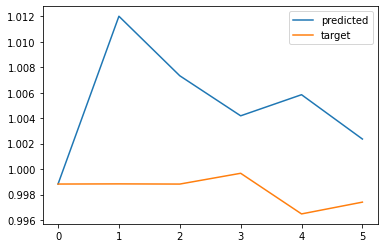

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

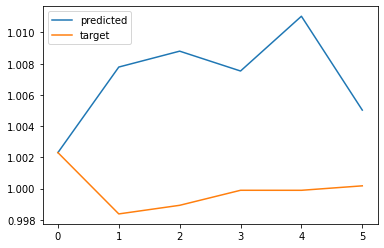

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

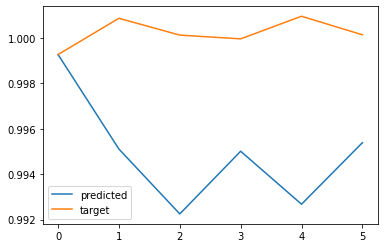

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

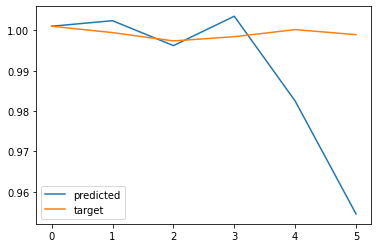

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

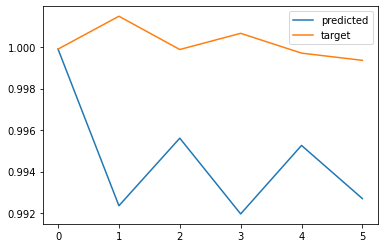

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

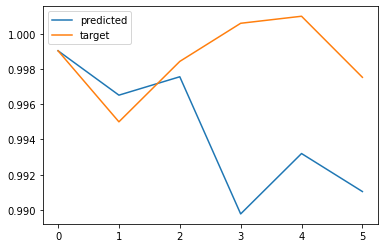

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

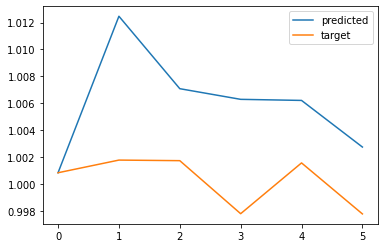

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

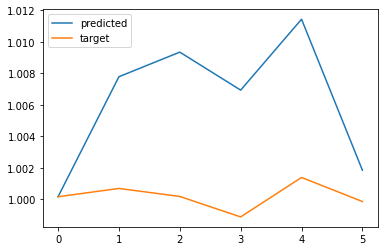

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

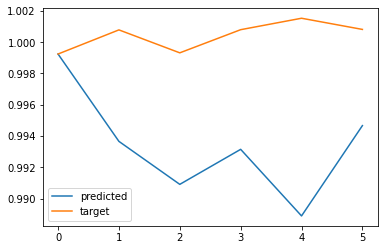

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

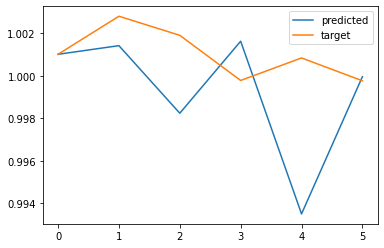

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

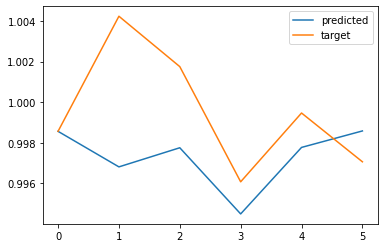

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

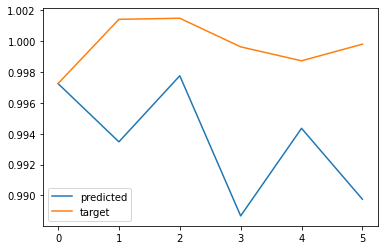

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

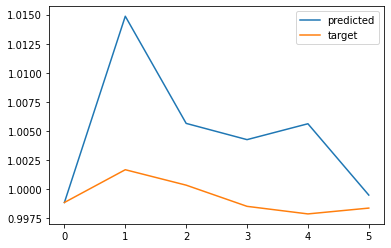

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

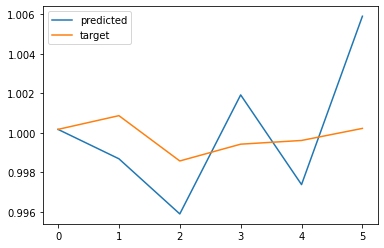

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

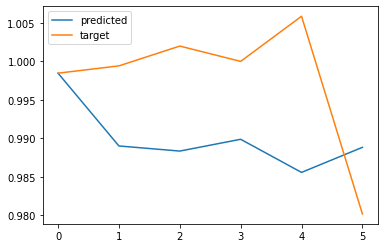

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

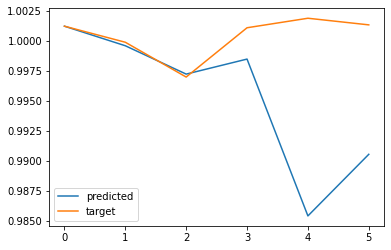

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

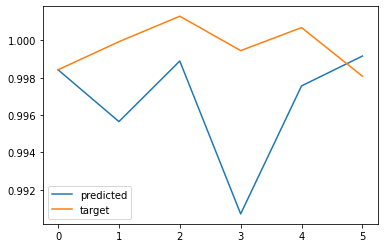

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

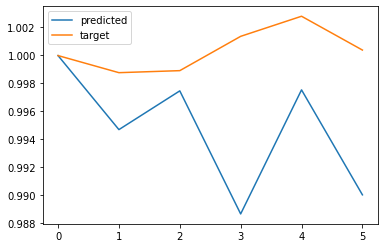

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

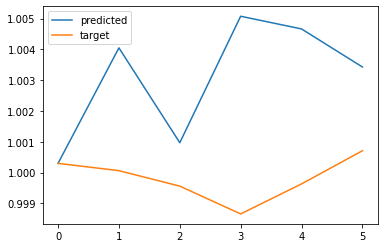

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

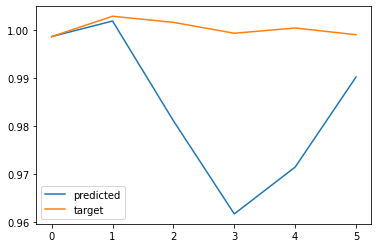

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

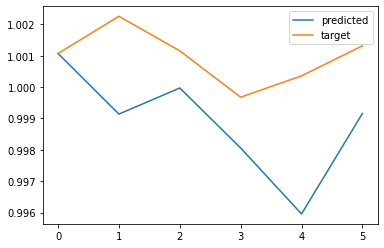

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

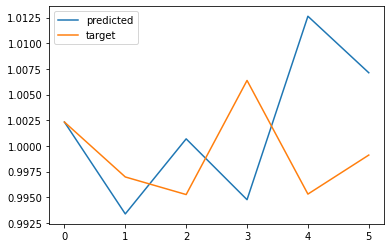

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

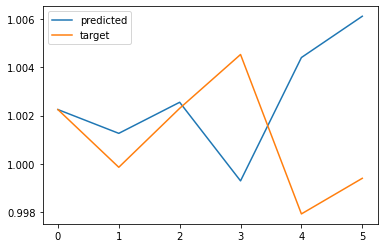

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

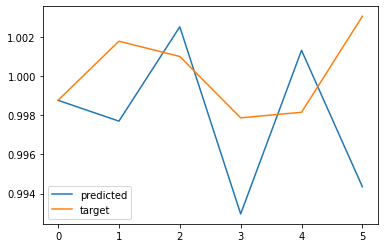

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

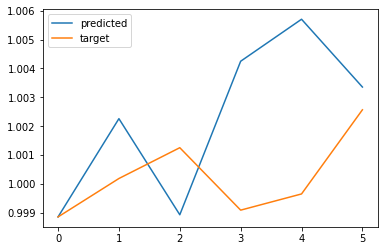

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

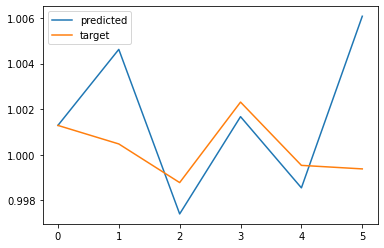

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

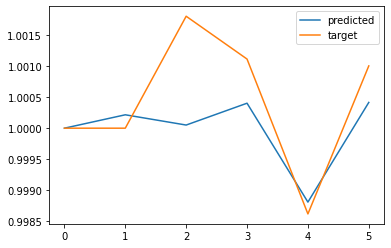

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

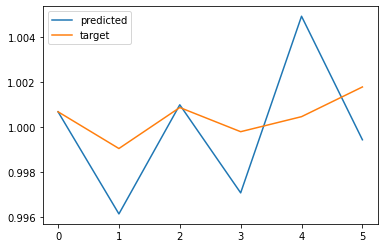

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

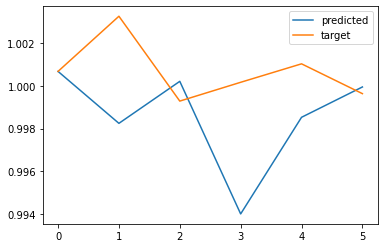

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

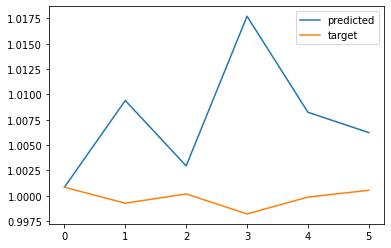

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

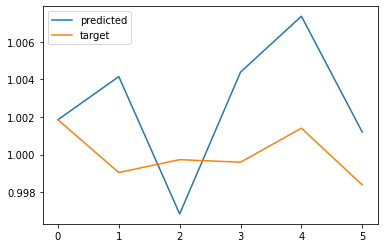

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

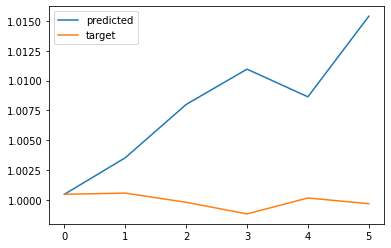

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

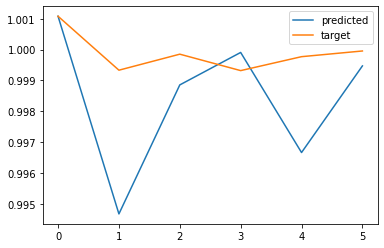

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

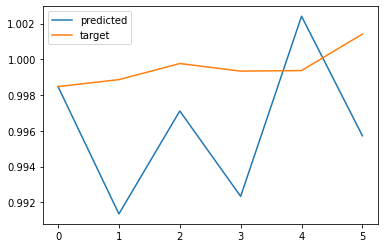

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

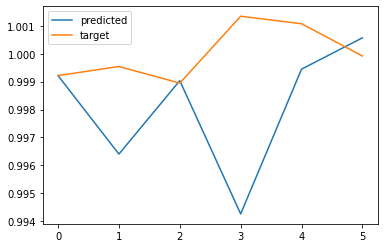

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

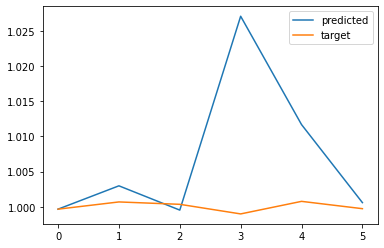

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

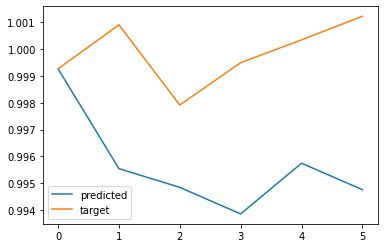

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

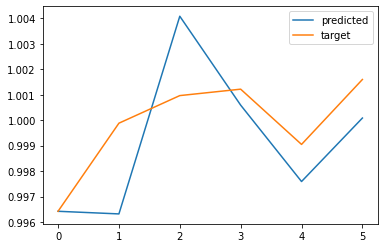

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

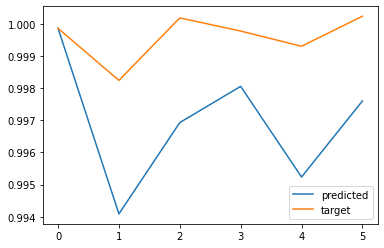

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

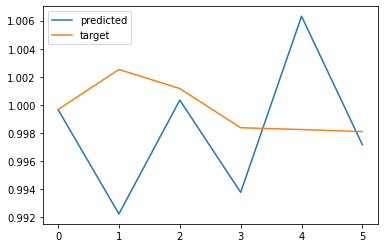

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

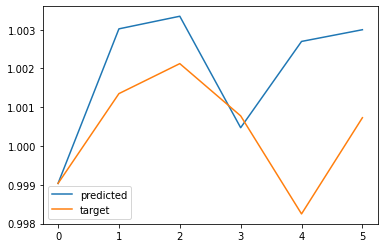

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

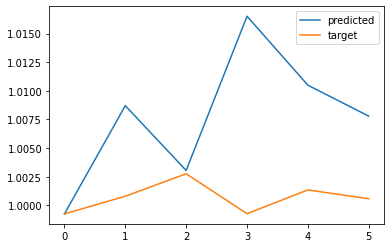

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

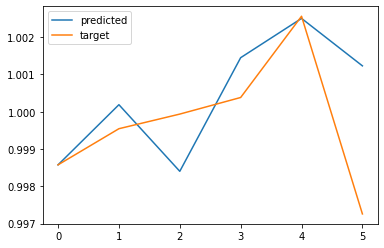

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

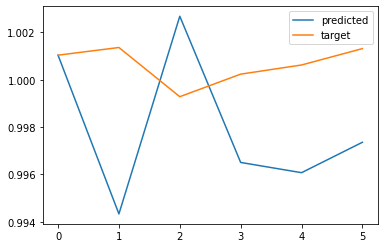

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

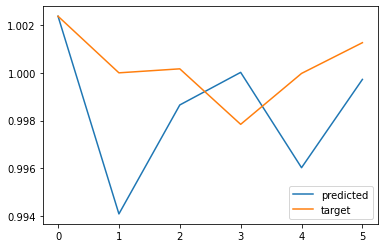

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

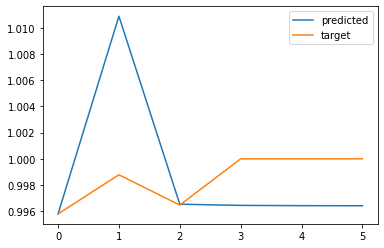

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

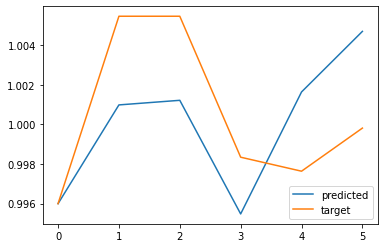

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

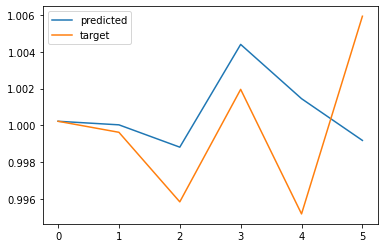

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

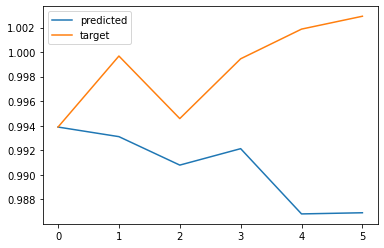

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

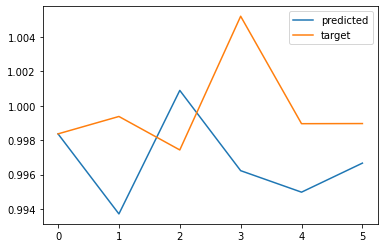

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

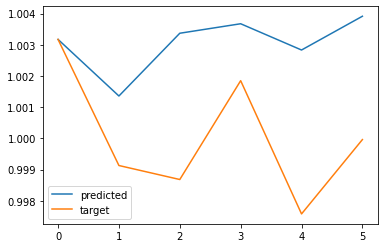

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

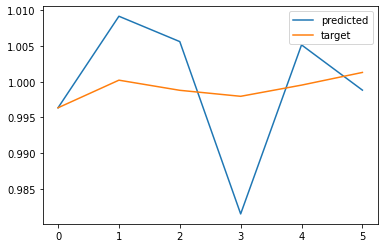

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

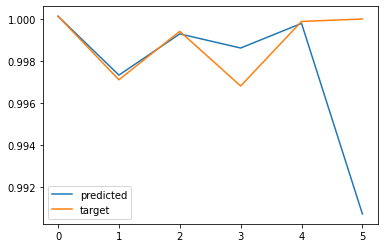

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

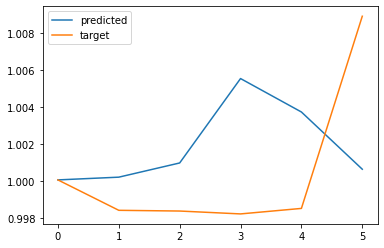

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

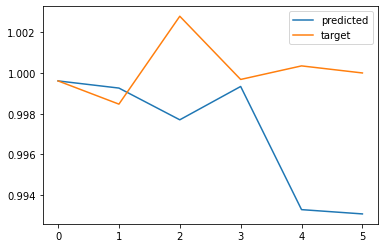

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

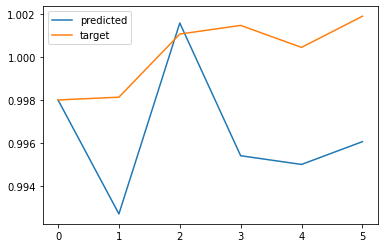

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

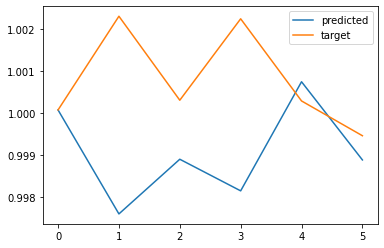

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

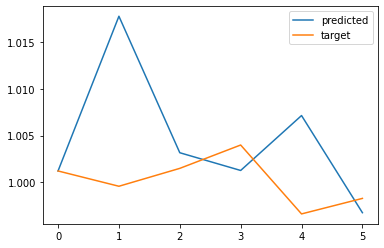

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

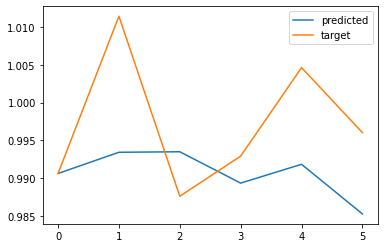

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

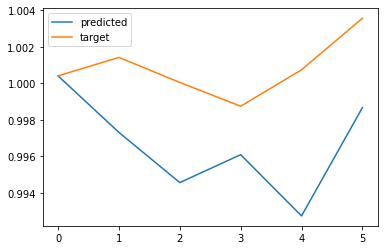

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

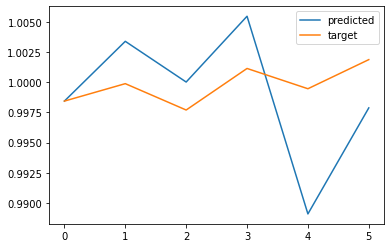

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

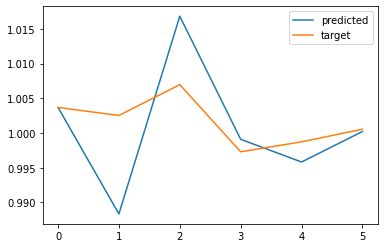

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

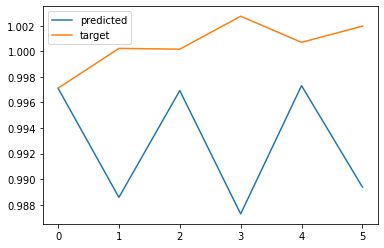

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

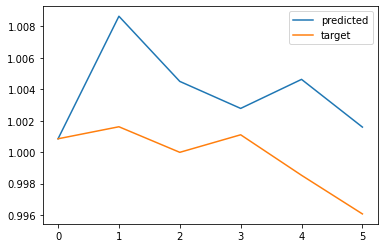

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

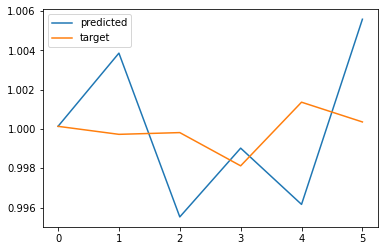

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

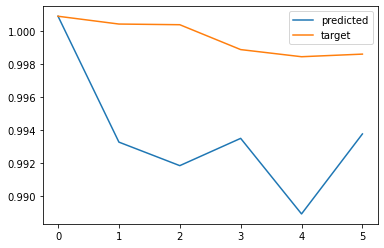

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

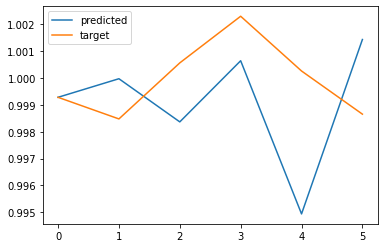

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

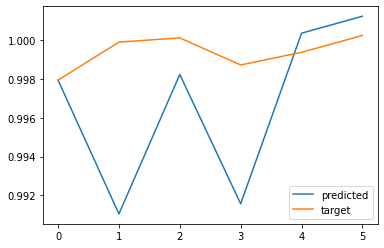

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

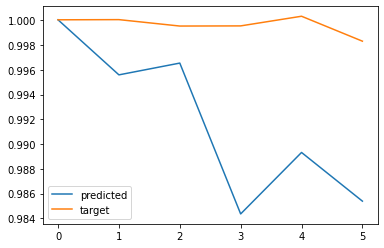

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

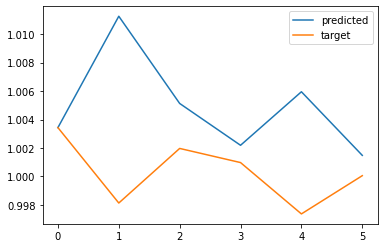

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

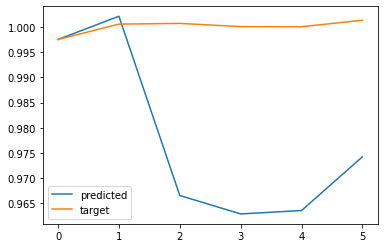

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

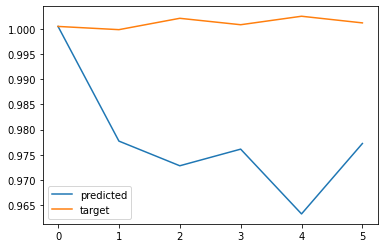

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

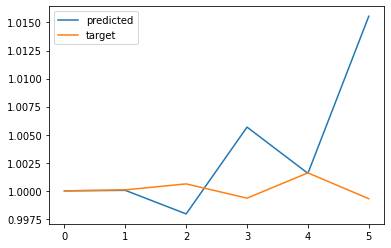

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

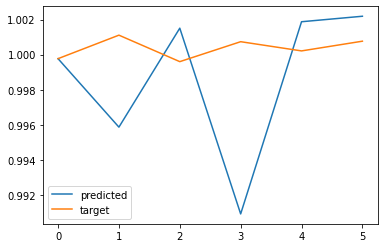

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

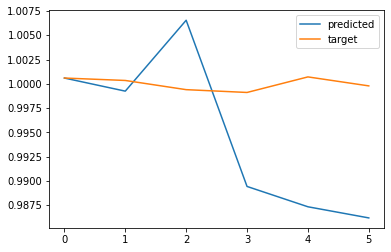

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

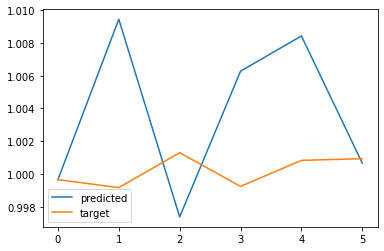

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

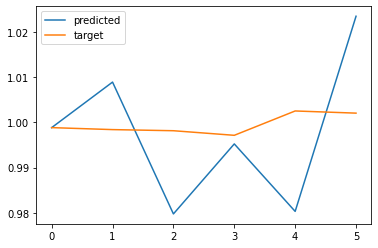

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

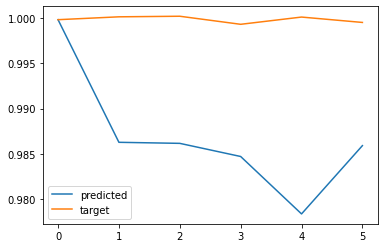

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

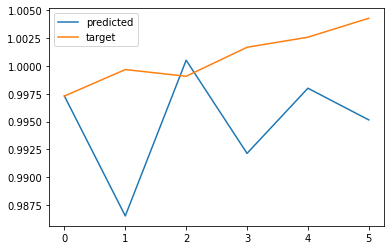

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

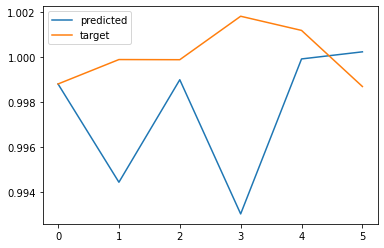

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

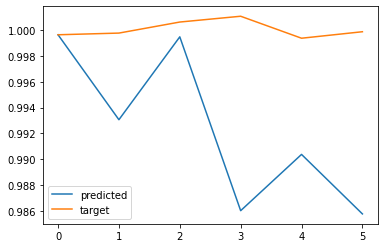

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

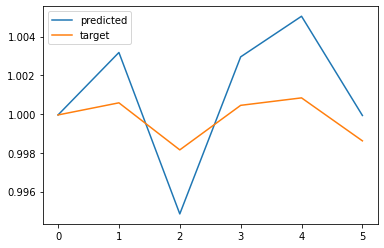

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

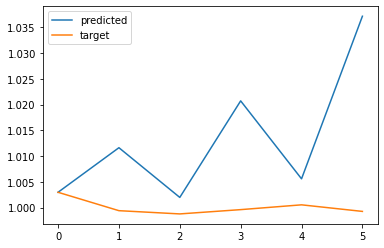

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

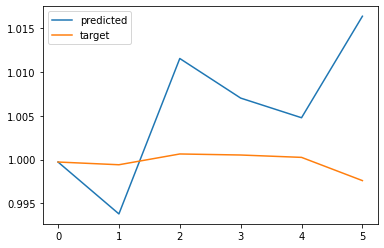

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

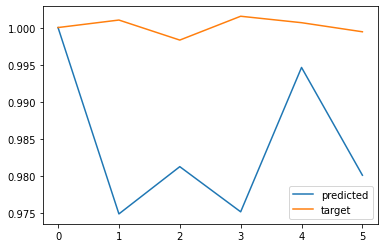

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

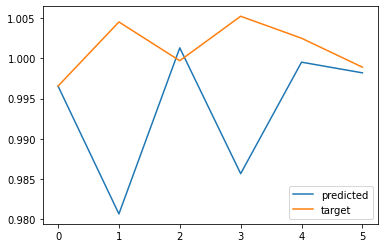

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

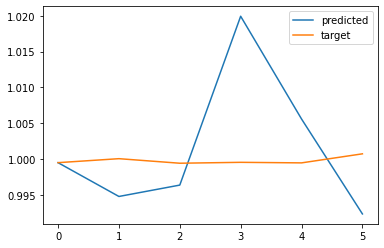

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

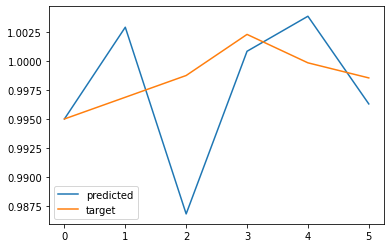

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

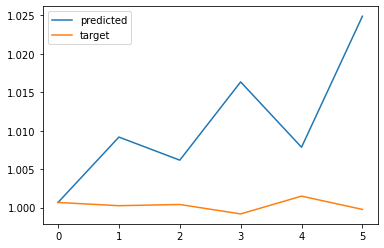

In [70]:
for batch in val_dataloader:
    past_cont = batch['past_cont'].to(device) 
    past_disc = batch['past_disc'].to(device) 
    target_seq = batch['target_seq'].to(device) 
    future_disc = batch['future_disc'].to(device)
        
    past_disc = one_hot(past_disc, [60, 24, 32, 13]) 
    future_disc = one_hot(future_disc, [60, 24, 32, 13]) 
        
    test_model.reset(batch_size=past_cont.shape[0], gpu=True) 
    with torch.no_grad():
        net_out, vs_weights = test_model(past_cont, past_disc, None, future_disc)  
    
    predicted = net_out[0,:,:].detach().cpu().numpy() 
    actual = target_seq[0,:,:].detach().cpu().numpy() 
    
    diff = actual[0] - predicted[0] 
    predicted += diff 
    
    plt.plot(predicted, label="predicted") 
    plt.plot(actual, label="target")
    plt.legend() 
    plt.show() 
                                    